In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix,roc_auc_score, roc_curve
from dataProcessing import dataSplit
from data import getData
import matplotlib.pyplot as plt
from keras.regularizers import l1
import talib
import datetime
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from xgboost import XGBClassifier, plot_importance
from tensorflow import set_random_seed
from numpy.random import seed
from keras.optimizers import Adam
import keras
from tensorflow import set_random_seed
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import load_model
from sklearn.model_selection import StratifiedKFold

In [9]:
end = datetime.datetime(year=2019,month=9,day=13)
start = datetime.datetime(year=2000,month=1,day=1)
# Defining the random state
seed(1)
set_random_seed(2)
#Text formatting
boldTextStart = "\033[1m"
boldTextEnd = "\033[0;0m"

In [4]:
def createFeatures(dataset,column):
    
    #Target variable construction
    dataset['Returns'] = np.log(dataset[column] / dataset[column].shift(1))
    dataset['Directions'] = np.sign(dataset['Returns'])
    dataset['Directions'] = np.where(dataset['Directions'] == 1, 1, 0)
    dataset['Directions'] = dataset['Directions']

    dataset['H-L'] = dataset['High'].shift(1) - dataset['Low'].shift(1)
    dataset['O-L'] = dataset['Open'].shift(1) - dataset['Low'].shift(1)
    dataset['C-L'] = dataset['Close'].shift(1) - dataset['Low'].shift(1)
    dataset['H-O'] = dataset['High'].shift(1) - dataset['Open'].shift(1)
    dataset['H-C'] = dataset['High'].shift(1) - dataset['Close'].shift(1)
    dataset['O-C'] = dataset['Open'].shift(1) - dataset['Close'].shift(1)
    #technical indicators
    dataset['ATR'] = talib.ATR(dataset['High'].shift(1).values, dataset['Low'].shift(1).values, dataset['Close'].shift(1).values, timeperiod=20)
    dataset['ADX'] = talib.ADX(dataset['High'].shift(1).values, dataset['Low'].shift(1).values, dataset['Close'].shift(1).values, timeperiod=5)
    dataset['RSI'] = talib.RSI(dataset['Close'].shift(1).values, timeperiod = 10)
    dataset['ADOSC'] = talib.ADOSC(dataset['High'].shift(1).values, dataset['Low'].shift(1).values,dataset['Close'].shift(1).values,np.asarray(dataset['Volume'].shift(1).values,dtype='float'), fastperiod=5, slowperiod=20)
    
    dataset['BB_Upper'], dataset['BB_Middle'], dataset['BB_Lower'] = talib.BBANDS(dataset['Close'].shift(1).values, timeperiod=20)
    dataset['CCI'] = talib.CCI(dataset['High'].shift(1).values, dataset['Low'].shift(1).values, dataset['Close'].shift(1).values, timeperiod=20)
    dataset['ROC'] = talib.ROC(dataset['Close'].shift(1).values, timeperiod=5)
    days_list = [5,10,50,100,200]
    dataset['FI_1'] = FORCE(dataset,1)
    dataset['FI_3'] = FORCE(dataset,3)
    dataset['FI_5'] = FORCE(dataset,5)
    for days in days_list:
        dataset['sma_%s' % days] = dataset['Close'].shift(1).rolling(window = days).mean()
        dataset['ewma_%s' % days]  = talib.EMA(dataset['Close'].shift(1).values,days)
    
    return dataset

def FORCE(dataset, n):  
    F = pd.Series(dataset['Close'].shift(1).diff(n) * dataset['Volume'].shift(1).diff(n), name = 'Force_' + str(n))  
    return F

In [5]:
def modelBuildXGB(X,y,n_estimator,learning_rate,max_depth,min_child_weight,gamma,colsample_bytree):
    xgb= XGBClassifier( n_estimator= n_estimator, 
                    learning_rate= learning_rate, 
                    max_depth= max_depth,  
                    min_child_weight=min_child_weight,
                    gamma=gamma,
                    colsample_bytree=colsample_bytree,
                    objective= 'binary:logistic', 
                    random_state= 2019,
                    n_jobs=-1)
    xgb.fit(X,y)
    return xgb

In [10]:
def create_model(xtrain,unit,optimizer,kernel_init,activation,reg):
    classifier = Sequential()
    classifier.add(Dense(units = unit, kernel_initializer = kernel_init, activation = activation,  
                         activity_regularizer=reg, input_dim = xtrain.shape[1]))
    classifier.add(Dense(units = 1, kernel_initializer = kernel_init, activation = 'sigmoid'))
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier
def train_model(model, xtrain, ytrain,checkpoint,stoppoint,batch_size,epochs):    
    model.fit(xtrain, ytrain, batch_size = batch_size, epochs = epochs, validation_split= 0.3 , 
              callbacks=[checkpoint, stoppoint],verbose=1)
    return model.history
def plotHistory(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
def plotMetrics(threshold, X_test_scaled, y_test):
    model = load_model('model.h5')
    y_pred = model.predict(X_test_scaled)
    y_pred = (y_pred > threshold)
    print(boldTextStart,'Accuracy:',boldTextEnd)
    accuracy_model = accuracy_score(y_test, y_pred, normalize=True)*100
    print(accuracy_model,' %')
    print(boldTextStart,'Confusion Matrix:',boldTextEnd)
    print(confusion_matrix(y_test,y_pred))
    print(boldTextStart,'Classification Report:',boldTextEnd)
    print(classification_report(y_test,y_pred))
    auc = roc_auc_score(y_test,y_pred)
    print(boldTextStart,'AUC Score: ',boldTextEnd, auc)

In [7]:
symbols = ['HDFCBANK.NS',
 'ICICIBANK.NS', 
 'SBIN.NS',
 'KOTAKBANK.NS',         
 'AXISBANK.NS']

HDFCBANK.NS
[[81  9]
 [12 69]]
0.8771929824561403
Plot feature importances...
AUC:  0.875925925925926
ICICIBANK.NS
[[83  9]
 [ 8 71]]
0.9005847953216374
Plot feature importances...
AUC:  0.900454045129334
SBIN.NS
[[75  3]
 [10 83]]
0.9239766081871345
Plot feature importances...
AUC:  0.9270057899090157
KOTAKBANK.NS
[[79  8]
 [ 8 76]]
0.9064327485380117
Plot feature importances...
AUC:  0.9064039408866994
AXISBANK.NS
[[84  5]
 [15 67]]
0.8830409356725146
Plot feature importances...
AUC:  0.8804466977254042


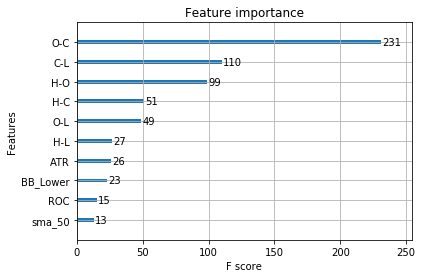

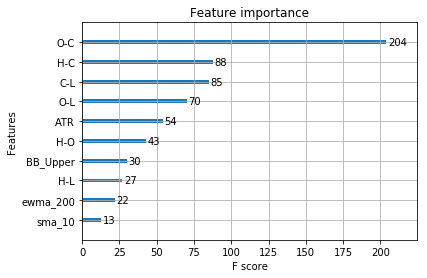

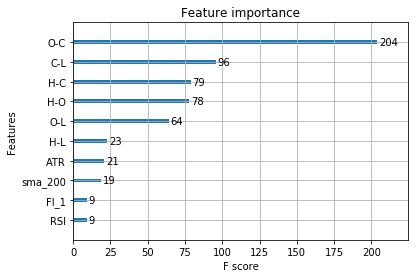

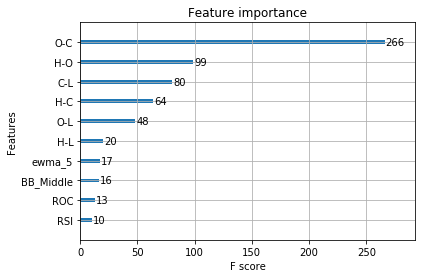

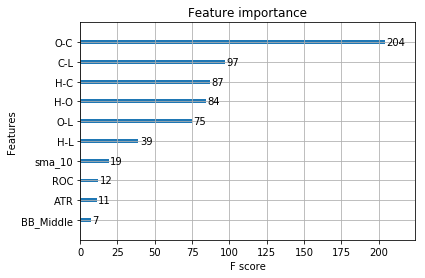

In [12]:
for symbol in symbols:
    print(symbol)
    data = getData(symbol,start,end)
    data = createFeatures(data,'Open')
    X_train,y_train,X_test,y_test = dataSplit(data,'2018','2019')
    stack = modelBuildXGB(X_train,y_train,200,0.0001,3,3,0.3,0.5)
    y_pred = stack.predict(X_test)
    print(confusion_matrix(y_test,y_pred))
    accuracy = accuracy_score(y_test,y_pred)
    print(accuracy)
    print('Plot feature importances...')
    plot_importance(stack, max_num_features=10)
    auc = roc_auc_score(y_test,y_pred)
    print('AUC: ', auc)

 HDFCBANK.NS 
Train on 3148 samples, validate on 1350 samples
Epoch 1/1000
3148/3148 [==============================] - 5s 2ms/step - loss: 0.4840 - acc: 0.7735 - val_loss: 0.5037 - val_acc: 0.8237
Epoch 2/1000
3148/3148 [==============================] - 6s 2ms/step - loss: 0.4362 - acc: 0.7983 - val_loss: 0.6965 - val_acc: 0.8030
Epoch 3/1000
3148/3148 [==============================] - 5s 2ms/step - loss: 0.4250 - acc: 0.8094 - val_loss: 0.5007 - val_acc: 0.8274
Epoch 4/1000
3148/3148 [==============================] - 6s 2ms/step - loss: 0.4177 - acc: 0.8113 - val_loss: 1.3764 - val_acc: 0.7319
Epoch 5/1000
3148/3148 [==============================] - 7s 2ms/step - loss: 0.4149 - acc: 0.8084 - val_loss: 1.2191 - val_acc: 0.7022
Epoch 6/1000
3148/3148 [==============================] - 5s 2ms/step - loss: 0.4147 - acc: 0.8167 - val_loss: 0.6622 - val_acc: 0.8156
Epoch 7/1000
3148/3148 [==============================] - 6s 2ms/step - loss: 0.4148 - acc: 0.8145 - val_loss: 3.2491 - va

Epoch 120/1000
3148/3148 [==============================] - 4s 1ms/step - loss: 0.3840 - acc: 0.8380 - val_loss: 6.1982 - val_acc: 0.5822
Epoch 121/1000
3148/3148 [==============================] - 5s 2ms/step - loss: 0.3885 - acc: 0.8364 - val_loss: 5.8381 - val_acc: 0.5837
Epoch 122/1000
3148/3148 [==============================] - 5s 1ms/step - loss: 0.3886 - acc: 0.8361 - val_loss: 6.2742 - val_acc: 0.5837
Epoch 123/1000
3148/3148 [==============================] - 4s 1ms/step - loss: 0.3930 - acc: 0.8389 - val_loss: 6.1668 - val_acc: 0.5741
Epoch 124/1000
3148/3148 [==============================] - 5s 1ms/step - loss: 0.3866 - acc: 0.8358 - val_loss: 6.2399 - val_acc: 0.5741
Epoch 125/1000
3148/3148 [==============================] - 4s 1ms/step - loss: 0.3845 - acc: 0.8389 - val_loss: 6.2107 - val_acc: 0.5733
Epoch 126/1000
3148/3148 [==============================] - 5s 1ms/step - loss: 0.3892 - acc: 0.8329 - val_loss: 5.8330 - val_acc: 0.5896
Epoch 127/1000
3148/3148 [========

3148/3148 [==============================] - 4s 1ms/step - loss: 0.3879 - acc: 0.8393 - val_loss: 6.1289 - val_acc: 0.5667
Epoch 239/1000
3148/3148 [==============================] - 6s 2ms/step - loss: 0.3879 - acc: 0.8402 - val_loss: 6.0779 - val_acc: 0.5889
Epoch 240/1000
3148/3148 [==============================] - 4s 1ms/step - loss: 0.3868 - acc: 0.8389 - val_loss: 5.9734 - val_acc: 0.5970
Epoch 241/1000
3148/3148 [==============================] - 6s 2ms/step - loss: 0.3925 - acc: 0.8335 - val_loss: 6.1977 - val_acc: 0.5889
Epoch 242/1000
3148/3148 [==============================] - 6s 2ms/step - loss: 0.3862 - acc: 0.8424 - val_loss: 6.1701 - val_acc: 0.5933
Epoch 243/1000
3148/3148 [==============================] - 5s 2ms/step - loss: 0.3875 - acc: 0.8440 - val_loss: 6.2617 - val_acc: 0.5807
Epoch 244/1000
3148/3148 [==============================] - 6s 2ms/step - loss: 0.3854 - acc: 0.8361 - val_loss: 6.3943 - val_acc: 0.5770
Epoch 245/1000
3148/3148 [=======================

3148/3148 [==============================] - 7s 2ms/step - loss: 0.3855 - acc: 0.8418 - val_loss: 7.2138 - val_acc: 0.5407
Epoch 357/1000
3148/3148 [==============================] - 5s 2ms/step - loss: 0.3805 - acc: 0.8437 - val_loss: 7.2172 - val_acc: 0.5407
Epoch 358/1000
3148/3148 [==============================] - 7s 2ms/step - loss: 0.3812 - acc: 0.8478 - val_loss: 7.1735 - val_acc: 0.5444
Epoch 359/1000
3148/3148 [==============================] - 6s 2ms/step - loss: 0.3826 - acc: 0.8367 - val_loss: 7.1760 - val_acc: 0.5452
Epoch 360/1000
3148/3148 [==============================] - 7s 2ms/step - loss: 0.3819 - acc: 0.8405 - val_loss: 7.2322 - val_acc: 0.5430
Epoch 361/1000
3148/3148 [==============================] - 7s 2ms/step - loss: 0.3799 - acc: 0.8434 - val_loss: 7.3174 - val_acc: 0.5363
Epoch 362/1000
3148/3148 [==============================] - 6s 2ms/step - loss: 0.3834 - acc: 0.8358 - val_loss: 7.3863 - val_acc: 0.5363
Epoch 363/1000
3148/3148 [=======================

3148/3148 [==============================] - 7s 2ms/step - loss: 0.3788 - acc: 0.8402 - val_loss: 6.7721 - val_acc: 0.5674
Epoch 475/1000
3148/3148 [==============================] - 5s 2ms/step - loss: 0.3868 - acc: 0.8377 - val_loss: 6.7556 - val_acc: 0.5659
Epoch 476/1000
3148/3148 [==============================] - 7s 2ms/step - loss: 0.3831 - acc: 0.8393 - val_loss: 6.7155 - val_acc: 0.5674
Epoch 477/1000
3148/3148 [==============================] - 6s 2ms/step - loss: 0.3839 - acc: 0.8447 - val_loss: 6.8653 - val_acc: 0.5644
Epoch 478/1000
3148/3148 [==============================] - 6s 2ms/step - loss: 0.3853 - acc: 0.8415 - val_loss: 6.7234 - val_acc: 0.5711
Epoch 479/1000
3148/3148 [==============================] - 7s 2ms/step - loss: 0.3848 - acc: 0.8399 - val_loss: 6.6713 - val_acc: 0.5733
Epoch 480/1000
3148/3148 [==============================] - 5s 2ms/step - loss: 0.3795 - acc: 0.8393 - val_loss: 6.4735 - val_acc: 0.5807
Epoch 481/1000
3148/3148 [=======================

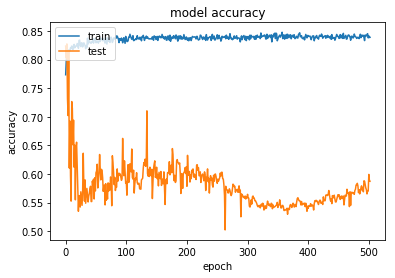

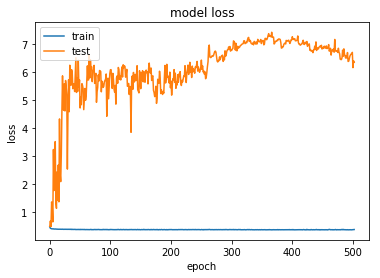

 HDFCBANK.NS 
 Accuracy: 
83.62573099415205  %
 Confusion Matrix: 
[[89  1]
 [27 54]]
 Classification Report: 
              precision    recall  f1-score   support

           0       0.77      0.99      0.86        90
           1       0.98      0.67      0.79        81

   micro avg       0.84      0.84      0.84       171
   macro avg       0.87      0.83      0.83       171
weighted avg       0.87      0.84      0.83       171

 AUC Score:   0.8277777777777777
 ICICIBANK.NS 
Train on 2711 samples, validate on 1163 samples
Epoch 1/1000
2711/2711 [==============================] - 8s 3ms/step - loss: 0.4405 - acc: 0.8008 - val_loss: 0.4139 - val_acc: 0.8616
Epoch 2/1000
2711/2711 [==============================] - 7s 2ms/step - loss: 0.3955 - acc: 0.8329 - val_loss: 0.9938 - val_acc: 0.7343: 0s - loss: 0.3937 - acc
Epoch 3/1000
2711/2711 [==============================] - 5s 2ms/step - loss: 0.3934 - acc: 0.8281 - val_loss: 0.5312 - val_acc: 0.8280
Epoch 4/1000
2711/2711 [=========

2711/2711 [==============================] - 5s 2ms/step - loss: 0.3656 - acc: 0.8484 - val_loss: 7.7956 - val_acc: 0.5013s - 
Epoch 116/1000
2711/2711 [==============================] - 5s 2ms/step - loss: 0.3639 - acc: 0.8491 - val_loss: 7.6971 - val_acc: 0.5039
Epoch 117/1000
2711/2711 [==============================] - 4s 1ms/step - loss: 0.3629 - acc: 0.8499 - val_loss: 7.3618 - val_acc: 0.5099
Epoch 118/1000
2711/2711 [==============================] - 5s 2ms/step - loss: 0.3687 - acc: 0.8488 - val_loss: 7.3664 - val_acc: 0.5142
Epoch 119/1000
2711/2711 [==============================] - 5s 2ms/step - loss: 0.3646 - acc: 0.8484 - val_loss: 7.2231 - val_acc: 0.5159
Epoch 120/1000
2711/2711 [==============================] - 4s 1ms/step - loss: 0.3679 - acc: 0.8484 - val_loss: 7.1562 - val_acc: 0.5219
Epoch 121/1000
2711/2711 [==============================] - 6s 2ms/step - loss: 0.3645 - acc: 0.8466 - val_loss: 7.4113 - val_acc: 0.5107
Epoch 122/1000
2711/2711 [===================

2711/2711 [==============================] - 6s 2ms/step - loss: 0.3648 - acc: 0.8528 - val_loss: 8.0001 - val_acc: 0.5030
Epoch 234/1000
2711/2711 [==============================] - 5s 2ms/step - loss: 0.3605 - acc: 0.8506 - val_loss: 8.0226 - val_acc: 0.5021
Epoch 235/1000
2711/2711 [==============================] - 4s 2ms/step - loss: 0.3623 - acc: 0.8506 - val_loss: 8.0019 - val_acc: 0.5030
Epoch 236/1000
2711/2711 [==============================] - 6s 2ms/step - loss: 0.3613 - acc: 0.8536 - val_loss: 8.0207 - val_acc: 0.5030
Epoch 237/1000
2711/2711 [==============================] - 6s 2ms/step - loss: 0.3592 - acc: 0.8502 - val_loss: 8.0227 - val_acc: 0.5013
Epoch 238/1000
2711/2711 [==============================] - 5s 2ms/step - loss: 0.3617 - acc: 0.8462 - val_loss: 8.0347 - val_acc: 0.5004
Epoch 239/1000
2711/2711 [==============================] - 5s 2ms/step - loss: 0.3633 - acc: 0.8517 - val_loss: 8.0062 - val_acc: 0.5021
Epoch 240/1000
2711/2711 [=======================

Epoch 292/1000
2711/2711 [==============================] - 1s 496us/step - loss: 0.3662 - acc: 0.8506 - val_loss: 8.0042 - val_acc: 0.5030
Epoch 293/1000
2711/2711 [==============================] - 1s 494us/step - loss: 0.3602 - acc: 0.8495 - val_loss: 8.0569 - val_acc: 0.5013
Epoch 294/1000
2711/2711 [==============================] - 1s 499us/step - loss: 0.3633 - acc: 0.8517 - val_loss: 8.0388 - val_acc: 0.5021
Epoch 295/1000
2711/2711 [==============================] - 1s 486us/step - loss: 0.3579 - acc: 0.8473 - val_loss: 8.0192 - val_acc: 0.5030
Epoch 296/1000
2711/2711 [==============================] - 1s 494us/step - loss: 0.3671 - acc: 0.8458 - val_loss: 8.0267 - val_acc: 0.5030
Epoch 297/1000
2711/2711 [==============================] - 1s 515us/step - loss: 0.3640 - acc: 0.8436 - val_loss: 7.9728 - val_acc: 0.5039
Epoch 298/1000
2711/2711 [==============================] - 1s 494us/step - loss: 0.3623 - acc: 0.8462 - val_loss: 8.0234 - val_acc: 0.5021
Epoch 299/1000
2711/

2711/2711 [==============================] - 2s 597us/step - loss: 0.3613 - acc: 0.8532 - val_loss: 8.1485 - val_acc: 0.4979
Epoch 409/1000
2711/2711 [==============================] - 1s 538us/step - loss: 0.3645 - acc: 0.8491 - val_loss: 8.1556 - val_acc: 0.4970
Epoch 410/1000
2711/2711 [==============================] - 2s 628us/step - loss: 0.3587 - acc: 0.8502 - val_loss: 8.1728 - val_acc: 0.4979
Epoch 411/1000
2711/2711 [==============================] - 2s 587us/step - loss: 0.3607 - acc: 0.8517 - val_loss: 8.1303 - val_acc: 0.4987
Epoch 412/1000
2711/2711 [==============================] - 2s 569us/step - loss: 0.3617 - acc: 0.8495 - val_loss: 8.1333 - val_acc: 0.4987
Epoch 413/1000
2711/2711 [==============================] - 1s 520us/step - loss: 0.3611 - acc: 0.8477 - val_loss: 8.1296 - val_acc: 0.4996
Epoch 414/1000
2711/2711 [==============================] - 1s 467us/step - loss: 0.3628 - acc: 0.8436 - val_loss: 8.1401 - val_acc: 0.4987
Epoch 415/1000
2711/2711 [=========

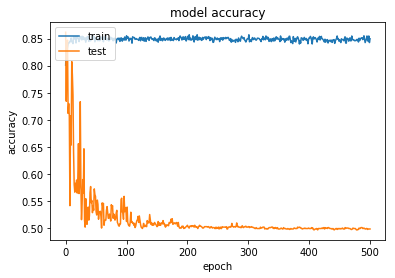

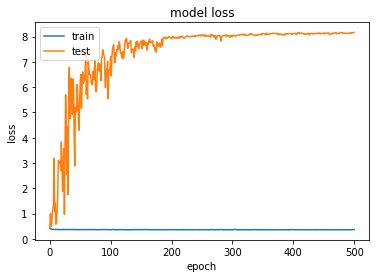

 ICICIBANK.NS 
 Accuracy: 
85.38011695906432  %
 Confusion Matrix: 
[[69 23]
 [ 2 77]]
 Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.75      0.85        92
           1       0.77      0.97      0.86        79

   micro avg       0.85      0.85      0.85       171
   macro avg       0.87      0.86      0.85       171
weighted avg       0.88      0.85      0.85       171

 AUC Score:   0.8623417721518987
 SBIN.NS 
Train on 3148 samples, validate on 1350 samples
Epoch 1/1000
3148/3148 [==============================] - 2s 602us/step - loss: 0.5050 - acc: 0.7510 - val_loss: 0.4054 - val_acc: 0.8785
Epoch 2/1000
3148/3148 [==============================] - 2s 508us/step - loss: 0.4563 - acc: 0.7814 - val_loss: 0.6056 - val_acc: 0.8089
Epoch 3/1000
3148/3148 [==============================] - 2s 687us/step - loss: 0.4459 - acc: 0.7821 - val_loss: 0.3691 - val_acc: 0.8785
Epoch 4/1000
3148/3148 [==============================] 

Epoch 56/1000
3148/3148 [==============================] - 2s 508us/step - loss: 0.4054 - acc: 0.8234 - val_loss: 1.0916 - val_acc: 0.8474
Epoch 57/1000
3148/3148 [==============================] - 2s 512us/step - loss: 0.4023 - acc: 0.8266 - val_loss: 1.9954 - val_acc: 0.7896
Epoch 58/1000
3148/3148 [==============================] - 2s 546us/step - loss: 0.4029 - acc: 0.8186 - val_loss: 1.5609 - val_acc: 0.8200
Epoch 59/1000
3148/3148 [==============================] - 2s 550us/step - loss: 0.4011 - acc: 0.8237 - val_loss: 1.1518 - val_acc: 0.8304
Epoch 60/1000
3148/3148 [==============================] - 2s 510us/step - loss: 0.4000 - acc: 0.8247 - val_loss: 1.1714 - val_acc: 0.8370
Epoch 61/1000
3148/3148 [==============================] - 2s 501us/step - loss: 0.4015 - acc: 0.8269 - val_loss: 1.2021 - val_acc: 0.8474
Epoch 62/1000
3148/3148 [==============================] - 2s 494us/step - loss: 0.4011 - acc: 0.8256 - val_loss: 1.2289 - val_acc: 0.8519
Epoch 63/1000
3148/3148 [==

Epoch 115/1000
3148/3148 [==============================] - 2s 497us/step - loss: 0.3951 - acc: 0.8266 - val_loss: 4.1985 - val_acc: 0.7000
Epoch 116/1000
3148/3148 [==============================] - 2s 500us/step - loss: 0.3952 - acc: 0.8297 - val_loss: 3.7414 - val_acc: 0.7267
Epoch 117/1000
3148/3148 [==============================] - 1s 466us/step - loss: 0.3905 - acc: 0.8281 - val_loss: 3.4459 - val_acc: 0.7489
Epoch 118/1000
3148/3148 [==============================] - 2s 481us/step - loss: 0.3914 - acc: 0.8281 - val_loss: 3.5492 - val_acc: 0.7333
Epoch 119/1000
3148/3148 [==============================] - 1s 472us/step - loss: 0.3925 - acc: 0.8278 - val_loss: 2.6087 - val_acc: 0.7941
Epoch 120/1000
3148/3148 [==============================] - 1s 468us/step - loss: 0.3982 - acc: 0.8259 - val_loss: 3.4098 - val_acc: 0.7481
Epoch 121/1000
3148/3148 [==============================] - 2s 484us/step - loss: 0.3912 - acc: 0.8281 - val_loss: 4.1286 - val_acc: 0.6993
Epoch 122/1000
3148/

3148/3148 [==============================] - 1s 468us/step - loss: 0.3805 - acc: 0.8310 - val_loss: 5.7380 - val_acc: 0.6200
Epoch 232/1000
3148/3148 [==============================] - 2s 490us/step - loss: 0.3888 - acc: 0.8262 - val_loss: 4.9915 - val_acc: 0.6644
Epoch 233/1000
3148/3148 [==============================] - 2s 500us/step - loss: 0.3806 - acc: 0.8259 - val_loss: 5.3969 - val_acc: 0.6452
Epoch 234/1000
3148/3148 [==============================] - 2s 512us/step - loss: 0.3815 - acc: 0.8329 - val_loss: 5.5149 - val_acc: 0.6378
Epoch 235/1000
3148/3148 [==============================] - 1s 474us/step - loss: 0.3753 - acc: 0.8339 - val_loss: 4.9495 - val_acc: 0.6711
Epoch 236/1000
3148/3148 [==============================] - 2s 507us/step - loss: 0.3861 - acc: 0.8266 - val_loss: 5.1629 - val_acc: 0.6593
Epoch 237/1000
3148/3148 [==============================] - 2s 482us/step - loss: 0.3834 - acc: 0.8266 - val_loss: 5.0164 - val_acc: 0.6659
Epoch 238/1000
3148/3148 [=========

3148/3148 [==============================] - 1s 468us/step - loss: 0.3859 - acc: 0.8278 - val_loss: 5.7980 - val_acc: 0.6222
Epoch 348/1000
3148/3148 [==============================] - 2s 494us/step - loss: 0.3752 - acc: 0.8326 - val_loss: 5.5501 - val_acc: 0.6422
Epoch 349/1000
3148/3148 [==============================] - 2s 727us/step - loss: 0.3789 - acc: 0.8342 - val_loss: 5.5355 - val_acc: 0.6400
Epoch 350/1000
3148/3148 [==============================] - 2s 700us/step - loss: 0.3782 - acc: 0.8294 - val_loss: 5.7313 - val_acc: 0.6319
Epoch 351/1000
3148/3148 [==============================] - 2s 516us/step - loss: 0.3817 - acc: 0.8256 - val_loss: 5.6564 - val_acc: 0.6378
Epoch 352/1000
3148/3148 [==============================] - 2s 581us/step - loss: 0.3814 - acc: 0.8288 - val_loss: 5.7342 - val_acc: 0.6326
Epoch 353/1000
3148/3148 [==============================] - 2s 545us/step - loss: 0.3815 - acc: 0.8234 - val_loss: 5.5085 - val_acc: 0.6400
Epoch 354/1000
3148/3148 [=========

3148/3148 [==============================] - 2s 498us/step - loss: 0.3846 - acc: 0.8297 - val_loss: 6.2094 - val_acc: 0.6007
Epoch 464/1000
3148/3148 [==============================] - 2s 518us/step - loss: 0.3779 - acc: 0.8323 - val_loss: 6.1475 - val_acc: 0.6067
Epoch 465/1000
3148/3148 [==============================] - 2s 501us/step - loss: 0.3769 - acc: 0.8297 - val_loss: 6.2875 - val_acc: 0.5941
Epoch 466/1000
3148/3148 [==============================] - 2s 525us/step - loss: 0.3770 - acc: 0.8332 - val_loss: 6.3634 - val_acc: 0.5911
Epoch 467/1000
3148/3148 [==============================] - 2s 478us/step - loss: 0.3766 - acc: 0.8380 - val_loss: 6.0193 - val_acc: 0.6156
Epoch 468/1000
3148/3148 [==============================] - 2s 510us/step - loss: 0.3821 - acc: 0.8301 - val_loss: 6.5021 - val_acc: 0.5807
Epoch 469/1000
3148/3148 [==============================] - 2s 500us/step - loss: 0.3783 - acc: 0.8304 - val_loss: 6.3898 - val_acc: 0.5874
Epoch 470/1000
3148/3148 [=========

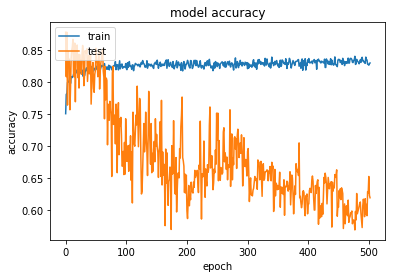

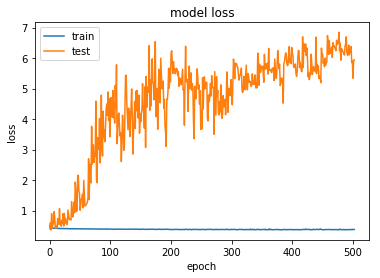

 SBIN.NS 
 Accuracy: 
91.81286549707602  %
 Confusion Matrix: 
[[74  4]
 [10 83]]
 Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.95      0.91        78
           1       0.95      0.89      0.92        93

   micro avg       0.92      0.92      0.92       171
   macro avg       0.92      0.92      0.92       171
weighted avg       0.92      0.92      0.92       171

 AUC Score:   0.9205955334987593
 KOTAKBANK.NS 
Train on 2886 samples, validate on 1237 samples
Epoch 1/1000
2886/2886 [==============================] - 2s 686us/step - loss: 0.4681 - acc: 0.7717 - val_loss: 1.1836 - val_acc: 0.7696
Epoch 2/1000
2886/2886 [==============================] - 1s 517us/step - loss: 0.4159 - acc: 0.7994 - val_loss: 1.0042 - val_acc: 0.7809
Epoch 3/1000
2886/2886 [==============================] - 1s 505us/step - loss: 0.3958 - acc: 0.8094 - val_loss: 0.5560 - val_acc: 0.8650
Epoch 4/1000
2886/2886 [==============================] 

Epoch 56/1000
2886/2886 [==============================] - 2s 521us/step - loss: 0.3593 - acc: 0.8468 - val_loss: 2.5948 - val_acc: 0.8254
Epoch 57/1000
2886/2886 [==============================] - 1s 502us/step - loss: 0.3630 - acc: 0.8468 - val_loss: 2.9913 - val_acc: 0.8011
Epoch 58/1000
2886/2886 [==============================] - 2s 534us/step - loss: 0.3659 - acc: 0.8496 - val_loss: 2.4739 - val_acc: 0.8189
Epoch 59/1000
2886/2886 [==============================] - 1s 519us/step - loss: 0.3677 - acc: 0.8385 - val_loss: 2.3879 - val_acc: 0.8213
Epoch 60/1000
2886/2886 [==============================] - 1s 513us/step - loss: 0.3577 - acc: 0.8468 - val_loss: 3.0600 - val_acc: 0.7866
Epoch 61/1000
2886/2886 [==============================] - 1s 490us/step - loss: 0.3610 - acc: 0.8358 - val_loss: 2.4864 - val_acc: 0.8222
Epoch 62/1000
2886/2886 [==============================] - 1s 493us/step - loss: 0.3570 - acc: 0.8455 - val_loss: 2.4419 - val_acc: 0.8189
Epoch 63/1000
2886/2886 [==

Epoch 115/1000
2886/2886 [==============================] - 1s 484us/step - loss: 0.3696 - acc: 0.8423 - val_loss: 4.2366 - val_acc: 0.7421
Epoch 116/1000
2886/2886 [==============================] - 2s 523us/step - loss: 0.3574 - acc: 0.8465 - val_loss: 4.7451 - val_acc: 0.7195
Epoch 117/1000
2886/2886 [==============================] - 1s 491us/step - loss: 0.3575 - acc: 0.8430 - val_loss: 3.8458 - val_acc: 0.7664
Epoch 118/1000
2886/2886 [==============================] - 1s 483us/step - loss: 0.3576 - acc: 0.8420 - val_loss: 3.8594 - val_acc: 0.7680
Epoch 119/1000
2886/2886 [==============================] - 1s 479us/step - loss: 0.3487 - acc: 0.8465 - val_loss: 4.4422 - val_acc: 0.7300
Epoch 120/1000
2886/2886 [==============================] - 1s 481us/step - loss: 0.3563 - acc: 0.8448 - val_loss: 3.7575 - val_acc: 0.7704
Epoch 121/1000
2886/2886 [==============================] - 1s 519us/step - loss: 0.3531 - acc: 0.8507 - val_loss: 4.4163 - val_acc: 0.7348
Epoch 122/1000
2886/

2886/2886 [==============================] - 1s 476us/step - loss: 0.3598 - acc: 0.8479 - val_loss: 6.8917 - val_acc: 0.5998
Epoch 232/1000
2886/2886 [==============================] - 1s 478us/step - loss: 0.3574 - acc: 0.8503 - val_loss: 6.6685 - val_acc: 0.6136
Epoch 233/1000
2886/2886 [==============================] - 1s 479us/step - loss: 0.3547 - acc: 0.8458 - val_loss: 6.6687 - val_acc: 0.6152
Epoch 234/1000
2886/2886 [==============================] - 1s 476us/step - loss: 0.3658 - acc: 0.8524 - val_loss: 6.6463 - val_acc: 0.6160
Epoch 235/1000
2886/2886 [==============================] - 1s 474us/step - loss: 0.3664 - acc: 0.8517 - val_loss: 6.2761 - val_acc: 0.6362
Epoch 236/1000
2886/2886 [==============================] - 1s 473us/step - loss: 0.3595 - acc: 0.8503 - val_loss: 6.6636 - val_acc: 0.6128
Epoch 237/1000
2886/2886 [==============================] - 1s 479us/step - loss: 0.3548 - acc: 0.8545 - val_loss: 6.8695 - val_acc: 0.5998
Epoch 238/1000
2886/2886 [=========

2886/2886 [==============================] - 1s 466us/step - loss: 0.3567 - acc: 0.8507 - val_loss: 7.8270 - val_acc: 0.5505
Epoch 348/1000
2886/2886 [==============================] - 1s 465us/step - loss: 0.3512 - acc: 0.8562 - val_loss: 8.0420 - val_acc: 0.5416
Epoch 349/1000
2886/2886 [==============================] - 1s 467us/step - loss: 0.3539 - acc: 0.8524 - val_loss: 8.1111 - val_acc: 0.5384
Epoch 350/1000
2886/2886 [==============================] - 1s 466us/step - loss: 0.3584 - acc: 0.8451 - val_loss: 8.1528 - val_acc: 0.5335
Epoch 351/1000
2886/2886 [==============================] - 1s 465us/step - loss: 0.3589 - acc: 0.8500 - val_loss: 8.1463 - val_acc: 0.5368
Epoch 352/1000
2886/2886 [==============================] - 1s 465us/step - loss: 0.3659 - acc: 0.8468 - val_loss: 8.1013 - val_acc: 0.5392
Epoch 353/1000
2886/2886 [==============================] - 1s 466us/step - loss: 0.3610 - acc: 0.8562 - val_loss: 8.1247 - val_acc: 0.5376
Epoch 354/1000
2886/2886 [=========

2886/2886 [==============================] - 1s 508us/step - loss: 0.3561 - acc: 0.8510 - val_loss: 8.4042 - val_acc: 0.5230
Epoch 464/1000
2886/2886 [==============================] - 1s 517us/step - loss: 0.3571 - acc: 0.8475 - val_loss: 8.3975 - val_acc: 0.5206
Epoch 465/1000
2886/2886 [==============================] - 1s 513us/step - loss: 0.3548 - acc: 0.8552 - val_loss: 8.3666 - val_acc: 0.5222
Epoch 466/1000
2886/2886 [==============================] - 1s 502us/step - loss: 0.3581 - acc: 0.8496 - val_loss: 8.3548 - val_acc: 0.5222
Epoch 467/1000
2886/2886 [==============================] - 1s 507us/step - loss: 0.3578 - acc: 0.8510 - val_loss: 8.3511 - val_acc: 0.5238
Epoch 468/1000
2886/2886 [==============================] - 1s 492us/step - loss: 0.3557 - acc: 0.8489 - val_loss: 8.3412 - val_acc: 0.5247
Epoch 469/1000
2886/2886 [==============================] - 1s 472us/step - loss: 0.3620 - acc: 0.8493 - val_loss: 8.3329 - val_acc: 0.5255
Epoch 470/1000
2886/2886 [=========

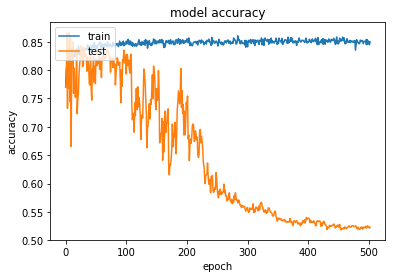

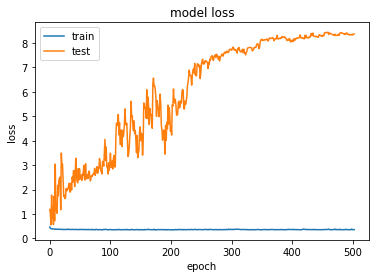

 KOTAKBANK.NS 
 Accuracy: 
88.30409356725146  %
 Confusion Matrix: 
[[72 15]
 [ 5 79]]
 Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.83      0.88        87
           1       0.84      0.94      0.89        84

   micro avg       0.88      0.88      0.88       171
   macro avg       0.89      0.88      0.88       171
weighted avg       0.89      0.88      0.88       171

 AUC Score:   0.8840311986863711
 AXISBANK.NS 
Train on 3147 samples, validate on 1350 samples
Epoch 1/1000
3147/3147 [==============================] - 2s 714us/step - loss: 0.5078 - acc: 0.7439 - val_loss: 0.4811 - val_acc: 0.8815
Epoch 2/1000
3147/3147 [==============================] - 2s 513us/step - loss: 0.4546 - acc: 0.7849 - val_loss: 0.6450 - val_acc: 0.8370
Epoch 3/1000
3147/3147 [==============================] - 2s 505us/step - loss: 0.4440 - acc: 0.7868 - val_loss: 0.4632 - val_acc: 0.8711
Epoch 4/1000
3147/3147 [============================

Epoch 56/1000
3147/3147 [==============================] - 2s 480us/step - loss: 0.4105 - acc: 0.8036 - val_loss: 5.7086 - val_acc: 0.6141
Epoch 57/1000
3147/3147 [==============================] - 2s 477us/step - loss: 0.4116 - acc: 0.8036 - val_loss: 5.5110 - val_acc: 0.6215
Epoch 58/1000
3147/3147 [==============================] - 2s 521us/step - loss: 0.4108 - acc: 0.8068 - val_loss: 5.8730 - val_acc: 0.5978
Epoch 59/1000
3147/3147 [==============================] - 2s 497us/step - loss: 0.4112 - acc: 0.8100 - val_loss: 5.2220 - val_acc: 0.6296
Epoch 60/1000
3147/3147 [==============================] - 2s 479us/step - loss: 0.4093 - acc: 0.8004 - val_loss: 5.0930 - val_acc: 0.6385
Epoch 61/1000
3147/3147 [==============================] - 2s 522us/step - loss: 0.4078 - acc: 0.8084 - val_loss: 4.5836 - val_acc: 0.6667
Epoch 62/1000
3147/3147 [==============================] - 2s 500us/step - loss: 0.4150 - acc: 0.7992 - val_loss: 6.7940 - val_acc: 0.5659
Epoch 63/1000
3147/3147 [==

Epoch 115/1000
3147/3147 [==============================] - 2s 499us/step - loss: 0.4096 - acc: 0.8027 - val_loss: 5.7972 - val_acc: 0.6319
Epoch 116/1000
3147/3147 [==============================] - 2s 503us/step - loss: 0.4084 - acc: 0.8074 - val_loss: 5.8292 - val_acc: 0.6244
Epoch 117/1000
3147/3147 [==============================] - 2s 501us/step - loss: 0.4107 - acc: 0.8011 - val_loss: 4.5895 - val_acc: 0.6970
Epoch 118/1000
3147/3147 [==============================] - 2s 500us/step - loss: 0.4078 - acc: 0.8093 - val_loss: 5.7052 - val_acc: 0.6363
Epoch 119/1000
3147/3147 [==============================] - 2s 500us/step - loss: 0.4073 - acc: 0.8049 - val_loss: 5.6777 - val_acc: 0.6341
Epoch 120/1000
3147/3147 [==============================] - 2s 500us/step - loss: 0.4066 - acc: 0.8039 - val_loss: 5.5789 - val_acc: 0.6356
Epoch 121/1000
3147/3147 [==============================] - 2s 499us/step - loss: 0.4064 - acc: 0.8093 - val_loss: 5.7323 - val_acc: 0.6296
Epoch 122/1000
3147/

Epoch 232/1000
3147/3147 [==============================] - 4s 1ms/step - loss: 0.4092 - acc: 0.8122 - val_loss: 5.3525 - val_acc: 0.6600
Epoch 233/1000
3147/3147 [==============================] - 4s 1ms/step - loss: 0.4132 - acc: 0.8065 - val_loss: 5.1948 - val_acc: 0.6711
Epoch 234/1000
3147/3147 [==============================] - 4s 1ms/step - loss: 0.4097 - acc: 0.8093 - val_loss: 4.5105 - val_acc: 0.7089
Epoch 235/1000
3147/3147 [==============================] - 4s 1ms/step - loss: 0.4125 - acc: 0.8078 - val_loss: 5.1847 - val_acc: 0.6704
Epoch 236/1000
3147/3147 [==============================] - 4s 1ms/step - loss: 0.4095 - acc: 0.8065 - val_loss: 5.3044 - val_acc: 0.6622
Epoch 237/1000
3147/3147 [==============================] - 4s 1ms/step - loss: 0.4113 - acc: 0.8065 - val_loss: 5.3069 - val_acc: 0.6630
Epoch 238/1000
3147/3147 [==============================] - 4s 1ms/step - loss: 0.4088 - acc: 0.8058 - val_loss: 5.1124 - val_acc: 0.6741
Epoch 239/1000
3147/3147 [========

Epoch 350/1000
3147/3147 [==============================] - 7s 2ms/step - loss: 0.4126 - acc: 0.8030 - val_loss: 6.1973 - val_acc: 0.6178
Epoch 351/1000
3147/3147 [==============================] - 7s 2ms/step - loss: 0.4126 - acc: 0.8030 - val_loss: 6.3157 - val_acc: 0.6081
Epoch 352/1000
3147/3147 [==============================] - 7s 2ms/step - loss: 0.4115 - acc: 0.8058 - val_loss: 6.1910 - val_acc: 0.6141
Epoch 353/1000
3147/3147 [==============================] - 10s 3ms/step - loss: 0.4097 - acc: 0.8033 - val_loss: 6.2121 - val_acc: 0.6148
Epoch 354/1000
3147/3147 [==============================] - 10s 3ms/step - loss: 0.4112 - acc: 0.8087 - val_loss: 5.7474 - val_acc: 0.6407
Epoch 355/1000
3147/3147 [==============================] - 9s 3ms/step - loss: 0.4101 - acc: 0.8078 - val_loss: 5.9543 - val_acc: 0.6281
Epoch 356/1000
3147/3147 [==============================] - 9s 3ms/step - loss: 0.4131 - acc: 0.8039 - val_loss: 5.9209 - val_acc: 0.6333
Epoch 357/1000
3147/3147 [======

3147/3147 [==============================] - 6s 2ms/step - loss: 0.4155 - acc: 0.8030 - val_loss: 5.5296 - val_acc: 0.6563
Epoch 469/1000
3147/3147 [==============================] - 6s 2ms/step - loss: 0.4128 - acc: 0.8065 - val_loss: 5.4274 - val_acc: 0.6578
Epoch 470/1000
3147/3147 [==============================] - 6s 2ms/step - loss: 0.4083 - acc: 0.8065 - val_loss: 5.5085 - val_acc: 0.6541
Epoch 471/1000
3147/3147 [==============================] - 6s 2ms/step - loss: 0.4109 - acc: 0.8055 - val_loss: 5.2880 - val_acc: 0.6681
Epoch 472/1000
3147/3147 [==============================] - 6s 2ms/step - loss: 0.4098 - acc: 0.8093 - val_loss: 5.9032 - val_acc: 0.6311
Epoch 473/1000
2564/3147 [=======================>......] - ETA: 0s - loss: 0.4069 - acc: 0.8081

In [ ]:
for symbol in symbols:
    print(boldTextStart,symbol,boldTextEnd)
    data = getData(symbol,start,end)
    data = createFeatures(data,'Open')
    X_train,y_train,X_test,y_test = dataSplit(data,'2018','2019')
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    unit = 20
    kernel_init = 'glorot_normal'
    activation = 'relu'
    reg = l1(0.001)
    checkpoint = keras.callbacks.ModelCheckpoint('model.h5', verbose=0, monitor='val_acc',save_best_only=True, mode='auto')
    stoppoint = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=500)
    batch_size = 2
    epochs = 1000
    threshold = 0.5
    model = None
    model = create_model(X_train_scaled,unit,optimizer,kernel_init,activation,reg)
    history = train_model(model, X_train_scaled, y_train,checkpoint,stoppoint,batch_size,epochs)
    accuracy_history = history.history['acc']
    val_accuracy_history = history.history['val_acc']
    print("Last training accuracy: ",str(accuracy_history[-1]), ", last validation accuracy: ",str(val_accuracy_history[-1]))
    plotHistory(history)
    print(boldTextStart,symbol,boldTextEnd)
    plotMetrics(threshold, X_test_scaled, y_test)    